<a href="https://colab.research.google.com/github/jenhaoyang/ml_blog/blob/main/%E7%B4%94pytorch_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  


# the VOC object classes.
CLASSES = (
  "Brazilian",
  "Taiwanese",
  "American",
  "European",
  "Chinese",
)
CLASS2NUM = {class_:idx for idx, class_ in enumerate(CLASSES)}

In [ ]:
import torchvision
from PIL import Image

def load_image(idx, size, device="cpu"):
    filename = f"car/{str(idx).zfill(2)}.jpg"
    img = Image.open(filename)
    transforms = [torchvision.transforms.ToTensor()]
    try:
        width, height = size
    except TypeError:
        width = height = size
    scale = min(width / img.width, height / img.height)
    new_width, new_height = int(img.width * scale), int(img.height * scale)
    diff_width, diff_height = width - new_width, height - new_height
    resize = torchvision.transforms.Resize(size=(new_height, new_width))
    pad = torchvision.transforms.Pad(
        padding=(
            diff_width // 2,
            diff_height // 2,
            diff_width // 2 + diff_width % 2,
            diff_height // 2 + diff_height % 2,
        )
    )
    transforms = [resize, pad] + transforms
    transformation = torchvision.transforms.Compose(transforms)
    x = transformation(img).to(device)
    return x

In [ ]:
import torch

def load_image_batch(idxs, size, device="cpu"):
    imgs = [load_image(idx, size=size, device="cpu") for idx in idxs]
    x = torch.stack(imgs, 0)
    return x.to(device)

In [ ]:
from IPython.display import display

def show_images(x):
    transform = torchvision.transforms.ToPILImage()
    if x.dim() == 3:
        display(transform(x))
    elif x.dim() == 4:
        for xx in x:
            display(transform(xx))
    else:
        raise ValueError

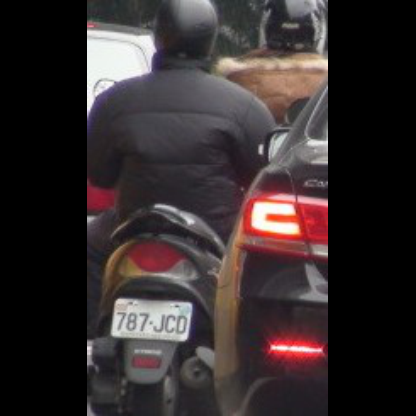

In [ ]:
imgs = load_image_batch([1], size=416)
show_images(imgs)

In [ ]:
import torch
torch.set_printoptions(precision=9)
class TinyYOLOv2(torch.nn.Module):
    def __init__(
        self,
        num_classes=5,
        anchors=(
            (1.08, 1.19),
            (3.42, 4.41),
            (6.63, 11.38),
            (9.42, 5.11),
            (16.62, 10.52),
        ),
    ):
        super().__init__()

        # Parameters
        self.register_buffer("anchors", torch.tensor(anchors))
        self.num_classes = num_classes

        # Layers
        self.relu = torch.nn.LeakyReLU(0.1, inplace=True)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.slowpool = torch.nn.MaxPool2d(2, 1)
        self.pad = torch.nn.ReflectionPad2d((0, 1, 0, 1))
        self.norm1 = torch.nn.BatchNorm2d(16, momentum=0.1)
        self.conv1 = torch.nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.norm2 = torch.nn.BatchNorm2d(32, momentum=0.1)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, 1, 1, bias=False)
        self.norm3 = torch.nn.BatchNorm2d(64, momentum=0.1)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.norm4 = torch.nn.BatchNorm2d(128, momentum=0.1)
        self.conv4 = torch.nn.Conv2d(64, 128, 3, 1, 1, bias=False)
        self.norm5 = torch.nn.BatchNorm2d(256, momentum=0.1)
        self.conv5 = torch.nn.Conv2d(128, 256, 3, 1, 1, bias=False)
        self.norm6 = torch.nn.BatchNorm2d(512, momentum=0.1)
        self.conv6 = torch.nn.Conv2d(256, 512, 3, 1, 1, bias=False)
        self.norm7 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv7 = torch.nn.Conv2d(512, 1024, 3, 1, 1, bias=False)


        self.norm8 = torch.nn.BatchNorm2d(512, momentum=0.1)
        self.conv8 = torch.nn.Conv2d(1024, 512, 1, 1, 0, bias=False)

        self.norm9 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv9 = torch.nn.Conv2d(512, 1024, 3, 1, 1, bias=False)

        self.conv10 = torch.nn.Conv2d(1024, len(anchors) * (5 + num_classes), 1, 1, 0)

    def forward(self, x, yolo=True):
        print(f"input shape {x.shape}")
        x = self.pool(self.relu(self.norm1(self.conv1(x))))
        
        # x = self.norm1(self.conv1(x))
        # print(f"shape: {x.shape}")
        # #print(f"!!!!!!!weight!!!!!!!{self.conv1.weight.data[:]}")
        # print(f"layer out {x[0, :, 0, 0]}")
        # x = self.pool(self.relu(x))


        x = self.pool(self.relu(self.norm2(self.conv2(x))))
        x = self.pool(self.relu(self.norm3(self.conv3(x))))
        x = self.pool(self.relu(self.norm4(self.conv4(x))))
        x = self.pool(self.relu(self.norm5(self.conv5(x))))
        x = self.slowpool(self.relu(self.pad(self.norm6(self.conv6(x)))))
        x = self.relu(self.norm7(self.conv7(x)))
        x = self.relu(self.norm8(self.conv8(x)))
        x = self.relu(self.norm9(self.conv9(x)))
        x = self.conv10(x)
        if yolo:
            x = self.yolo(x)
        return x
    
    def yolo(self, x):
        print(f"conv out shape {x.shape}")
        #print(f"one cell one image {x[0 , :, 0, 0]}")
        # store the original shape of x
        nB, _, nH, nW = x.shape #torch.Size([1, 125, 10, 10])
        #print(f"out[:, 1, :, :]:{x[:, 1, :, :]}")

        # reshape the x-tensor: (batch size, # anchors, height, width, 5+num_classes)
        x = x.view(nB, self.anchors.shape[0], -1, nH, nW).permute(0, 1, 3, 4, 2)

        # get normalized auxiliary tensors
        anchors = self.anchors.to(dtype=x.dtype, device=x.device)
        range_y, range_x = torch.meshgrid(
            torch.arange(nH, dtype=x.dtype, device=x.device),
            torch.arange(nW, dtype=x.dtype, device=x.device),
        )
        anchor_x, anchor_y = anchors[:, 0], anchors[:, 1]
        #print(f"range_x[None,None,:,:,None]: {range_x[None,None,:,:,None]}, range_y[None,None,:,:,None]: {range_y[None,None,:,:,None]}")
        #print(f"x[:, :, :, :, 0:1].sigmoid() :{x[:, :, :, :, 0:1].sigmoid()}")
        #print(f"range_x[None,None,:,:,None]:{range_x[None,None,:,:,None]}")
        
        # compute boxes.
        x = torch.cat([
            (x[:, :, :, :, 0:1].sigmoid() + range_x[None,None,:,:,None]) / nW,  # X center
            (x[:, :, :, :, 1:2].sigmoid() + range_y[None,None,:,:,None]) / nH,  # Y center
            (x[:, :, :, :, 2:3].exp() * anchor_x[None,:,None,None,None]) / nW,  # Width
            (x[:, :, :, :, 3:4].exp() * anchor_y[None,:,None,None,None]) / nH,  # Height
            x[:, :, :, :, 4:5].sigmoid(), # confidence
            x[:, :, :, :, 5:].softmax(-1), # classes
        ], -1)

        return x # (batch_size, # anchors, height, width, 5+num_classes)

In [ ]:
network = TinyYOLOv2()

In [ ]:
import numpy as np

def load_weights(network, filename="lp-detection-layout-classification.weights"):
    with open(filename, "rb") as file:
        version = np.fromfile(file, count=3, dtype=np.int32)
        seen_so_far = np.fromfile(file, count=1, dtype=np.int32)
        weights = np.fromfile(file, dtype=np.float32)
        print(f"weights.shape:{weights.shape}")
        idx = 1
        for layer in network.children():
            
            if isinstance(layer, torch.nn.Conv2d):
                if layer.bias is not None:
                    n = layer.bias.numel()
                    layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                    idx += n
                    #print(f"Conv2d bias: {layer.bias.data[:]}")
                n = layer.weight.numel()
                #layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                layer.weight.data.copy_(torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight))
                idx += n
                print(f"!!!!!!!!!!!Conv2d weight:\n {layer.weight.data[:]}")
                
                
                
            if isinstance(layer, torch.nn.BatchNorm2d):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                idx += n
                print(f"!!!!!!!!!!!BatchNorm2d bias:\n {layer.bias.data[:]}")

                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n
                print(f"!!!!!!!!!!!BatchNorm2d weight:\n {layer.weight.data[:]}")

                layer.running_mean.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.running_mean)
                idx += n
                print(f"!!!!!!!!!!!BatchNorm2d running_mean:\n {layer.running_mean.data[:]}")

                layer.running_var.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.running_var)
                idx += n
                print(f"!!!!!!!!!!!BatchNorm2d running_var:\n {layer.running_var.data[:]}")
                
                
            if isinstance(layer, torch.nn.Linear):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                idx += n
                print(f"!!!!!!!!!!!Linear bias:\n {layer.bias.data[:]}")

                n = layer.weight.numel()
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n
                print(f"!!!!!!!!!!!Linear weight:\n {layer.weight.data[:]}")

In [ ]:
load_weights(network)

weights.shape:(11598755,)
!!!!!!!!!!!BatchNorm2d bias:
 tensor([-2.497192144, -6.120598793,  0.701517344,  0.865674496, -4.975296497,
         2.273202181, -5.240960598, -8.124570847, -2.621843815,  1.028300285,
         0.903197944,  1.247869730,  0.388569683, -0.346555829,  1.730068684,
         1.185414433])
!!!!!!!!!!!BatchNorm2d weight:
 tensor([2.942082405, 4.389151096, 1.159458876, 1.569059253, 4.367416859,
        1.992294192, 3.930067778, 5.814538002, 3.421256065, 3.783794641,
        3.677327871, 3.924883127, 2.863399982, 2.386716366, 3.965405226,
        2.241647482])
!!!!!!!!!!!BatchNorm2d running_mean:
 tensor([-0.210451484,  0.161719456, -0.042589013,  0.046514288, -0.023150414,
        -0.010494006, -0.010753936, -0.315130860, -0.115330920,  0.007957878,
         0.006479484,  0.022195585, -0.038353249,  0.000650629,  0.018639946,
         0.023832306])
!!!!!!!!!!!BatchNorm2d running_var:
 tensor([0.040216900, 0.021279257, 0.027084703, 0.060603250, 0.036170632,
        0

In [ ]:
!python setup.py build_ext --inplace

setup.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
running build_ext
copying build/lib.linux-x86_64-3.7/cython_utils/nms.cpython-37m-x86_64-linux-gnu.so -> cython_utils
copying build/lib.linux-x86_64-3.7/cython_utils/cy_yolo2_findboxes.cpython-37m-x86_64-linux-gnu.so -> cython_utils
copying build/lib.linux-x86_64-3.7/cython_utils/cy_yolo_findboxes.cpython-37m-x86_64-linux-gnu.so -> cython_utils


In [ ]:
!pip install onnxruntime

In [ ]:
import onnxruntime
import cv2
import numpy as np
import pickle
from cython_utils.cy_yolo2_findboxes import box_constructor
import os
import json

def process_box(meta, b, h, w, threshold):
	max_indx = np.argmax(b.probs)
	max_prob = b.probs[max_indx]
	label = meta['labels'][max_indx]
	if max_prob > threshold:
		left  = int ((b.x - b.w/2.) * w)
		right = int ((b.x + b.w/2.) * w)
		top   = int ((b.y - b.h/2.) * h)
		bot   = int ((b.y + b.h/2.) * h)
		if left  < 0    :  left = 0
		if right > w - 1: right = w - 1
		if top   < 0    :   top = 0
		if bot   > h - 1:   bot = h - 1
		mess = '{}'.format(label)
		return (left, right, top, bot, mess, max_indx, max_prob)
	return None

def findboxes(meta, net_out):
	# meta
	meta = meta
	boxes = list()
	boxes=box_constructor(meta,net_out)
	return boxes


def postprocess(meta, net_out, im, save = True, out_json = False, imgdir='.'):
	"""
	Takes net output, draw net_out, save to disk
	"""
	boxes = findboxes(meta=meta, net_out=net_out)

	# meta
	meta = meta
	threshold = meta['thresh']
	colors = meta['colors']
	labels = meta['labels']
	if type(im) is not np.ndarray:
		imgcv = cv2.imread(im)
	else: imgcv = im
	h, w, _ = imgcv.shape
	
	resultsForJSON = []
	for b in boxes:
		boxResults = process_box(meta, b, h, w, threshold)
		if boxResults is None:
			continue
		left, right, top, bot, mess, max_indx, confidence = boxResults
		thick = int((h + w) // 300)
		if out_json:
			resultsForJSON.append({"label": mess, "confidence": float('%.2f' % confidence), "topleft": {"x": left, "y": top}, "bottomright": {"x": right, "y": bot}})
			continue

		cv2.rectangle(imgcv,
			(left, top), (right, bot),
			colors[max_indx], thick)
		cv2.putText(imgcv, mess, (left, top - 12),
			0, 1e-3 * h, colors[max_indx],thick//3)

	if not save: return imgcv

	#outfolder = os.path.join(imgdir, 'out')
	outfolder = "./aaa"
	img_name = os.path.join(outfolder, os.path.basename(im))
	if out_json:
		textJSON = json.dumps(resultsForJSON)
		textFile = os.path.splitext(img_name)[0] + ".json"
		with open(textFile, 'w') as f:
			f.write(textJSON)
		return resultsForJSON

	cv2.imwrite(img_name, imgcv)

In [ ]:
def pytorch_inference():
  image_src = cv2.imread('/content/car/05.jpg')

  IN_IMAGE_H = 416
  IN_IMAGE_W = 416

  # Input
  img_in = cv2.resize(image_src, (IN_IMAGE_W, IN_IMAGE_H), interpolation=cv2.INTER_LINEAR)
  img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
  img_in = np.transpose(img_in, (0, 1, 2)).astype(np.float32)
  img_in = np.expand_dims(img_in, axis=0)
  img_in /= 255.0
  img_tensor = torch.tensor(img_in).permute(0, 3, 1, 2)

  #img_tensor = torch.ones(1, 3, 416, 416)
  network.eval()
  #assert network.training != True
  with torch.no_grad():
    output_tensor = network(img_tensor, yolo=False)
  output_tensor = output_tensor.permute(0, 2, 3, 1)
  output_tensor = output_tensor.detach().contiguous().numpy()[0]
  print(output_tensor.shape)
  # for r in range(0, 13):
  #   for c in range(0, 13):
  #     print(f"output_tensor[r, c, :]:{output_tensor[r, c, :]}")
  #print(f"output_tensor[0, 0, :]:{output_tensor[0, 0, :]}")
  meta = dict({"net": {"type": "[net]", "batch": 64, "subdivisions": 8, "width": 416, "height": 416, "channels": 3, "momentum": 0.9, "decay": 0.0005, "angle": 0, "flip": 0, "saturation": 1, "exposure": 1.5, "hue": 0, "learning_rate": 0.0001, "burn_in": 1000, "max_batches": 90000, "policy": "steps", "steps": "100,72000,81000", "scales": "10,.1,.1"}, "type": "[region]", "anchors": [1.804, 1.1052, 2.5633, 1.3653, 3.3943, 1.3672, 4.6794, 1.6389, 2.9124, 2.7876], "bias_match": 1, "classes": 5, "coords": 4, "num": 5, "softmax": 1, "jitter": 0.2, "rescore": 1, "object_scale": 5, "noobject_scale": 1, "class_scale": 1, "coord_scale": 1, "absolute": 1, "thresh": 0.6, "random": 1, "model": "/home/ai_server/2005013/image_inference_system1/surveillance/licence_plate_conf/lp-detection-layout-classification.cfg", "inp_size": [416, 416, 3], "out_size": [13, 13, 50], "name": "lp-detection-layout-classification", "labels": ["Brazilian", "Taiwanese", "American", "European", "Chinese"], "colors": [[254.0, 254.0, 254], [222.25, 190.5, 127], [190.5, 127.0, 254], [158.75, 63.5, 127], [127.0, 254.0, 254]]})
  postprocess(meta=meta, net_out=output_tensor, im='/content/car/05.jpg')

In [ ]:
pytorch_inference()

input shape torch.Size([1, 3, 416, 416])
(13, 13, 50)
